In [78]:
import pandas as pd
import numpy as np
from numpy.random import seed
seed(1)
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import graphviz
import math
import warnings
from scipy.special import boxcox1p
import xgboost as xgb
from xgboost import plot_importance, XGBRegressor,plot_tree
from scipy.stats import skew
from scipy import stats
from scipy.stats.stats import pearsonr
from scipy.stats import norm
from collections import Counter
from sklearn.linear_model import LinearRegression,LassoCV, Ridge, LassoLarsCV,ElasticNetCV
from sklearn.model_selection import GridSearchCV, cross_val_score, learning_curve,train_test_split
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler, Normalizer, RobustScaler
from sklearn.metrics import accuracy_score,make_scorer,mean_squared_error
warnings.filterwarnings('ignore')
sns.set(style='white', context='notebook', palette='deep')
%config InlineBackend.figure_format = 'retina' #set 'png' here when working on notebook
%matplotlib inline

In [106]:
# Preliminary data analysis
#Clean the data
data =  pd.read_csv("clean_output1.csv",skipinitialspace=True).drop(['Unnamed: 0','log_p'],axis=1)
data.head()


,price,bedrooms,bathrooms,Sqft_of_home,sqft_lot,floors,waterfront,view,condition,grade,...,yr_built,Sqft_of_livinge_room_2015,Sqft_of_lot_2015,Median_Income,Mean_Income,population,people_employed,people_educated,bachelor_degrees,grad_degrees
0,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,...,1955,1340,5650,60839,74831,25363,12091,17242,3113,1370
1,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,...,1951,1690,7639,54561,77284,39254,21120,28365,8769,6040
2,180000.0,2,1.00,770,10000,1.0,0,0,3,6,...,1933,2720,8062,90588,106180,21568,10783,14892,4806,2727
3,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,...,1965,1360,5000,90625,106952,15415,9096,12025,4487,2404
4,257500.0,3,2.25,1715,6819,2.0,0,0,3,7,...,1995,2238,6819,46250,61010,46008,21432,30004,4648,1865


In [107]:
#Deal with categorical variables
df = data.copy()
df['yr_built'] = df['yr_built'].astype(str)
df['waterfront'] = df['waterfront'].astype(str)
df['condition'] = df['condition'].astype(str)
df['view'] = df['view'].astype(str)
df['grade'] = df['grade'].astype(str)
df.head()

,price,bedrooms,bathrooms,Sqft_of_home,sqft_lot,floors,waterfront,view,condition,grade,...,yr_built,Sqft_of_livinge_room_2015,Sqft_of_lot_2015,Median_Income,Mean_Income,population,people_employed,people_educated,bachelor_degrees,grad_degrees
0,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,...,1955,1340,5650,60839,74831,25363,12091,17242,3113,1370
1,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,...,1951,1690,7639,54561,77284,39254,21120,28365,8769,6040
2,180000.0,2,1.00,770,10000,1.0,0,0,3,6,...,1933,2720,8062,90588,106180,21568,10783,14892,4806,2727
3,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,...,1965,1360,5000,90625,106952,15415,9096,12025,4487,2404
4,257500.0,3,2.25,1715,6819,2.0,0,0,3,7,...,1995,2238,6819,46250,61010,46008,21432,30004,4648,1865


In [108]:
# Find skewed data and use the transformation
numeric_feats = df.dtypes[df.dtypes != "object"].index
numeric_feats
# Check the skew of all numerical features
skewed_feats = df[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewness = pd.DataFrame({'Skewed Features' :skewed_feats})
skewness

,Skewed Features
sqft_basement,1.206370
price,1.016693
sqft_above,0.795909
floors,0.765747
Mean_Income,0.568835
Sqft_of_livinge_room_2015,0.530359
sqft_lot,0.406968
Sqft_of_home,0.388251
grad_degrees,0.291600
Median_Income,0.281805


In [109]:
# Test and find the columns with skewness > 0.85
skewness = skewness[abs(skewness) > 0.85]
skewness = skewness.dropna(axis=0, how='any', thresh=None, subset=None, inplace=False)
print("There are {} skewed numerical features to log transform".format(skewness.shape[0]))
print(skewness)

There are 2 skewed numerical features to log transform
               Skewed Features
sqft_basement         1.206370
price                 1.016693


In [112]:
#log transformation
skewed_features = skewness.index
skewed_features = skewness.index
df[skewed_features] = np.log1p(df[skewed_features])

In [113]:
#one hot encoding
df2 = df.copy()
df2.drop('price', axis=1, inplace=True)
df2 = pd.get_dummies(df2)

df2.head()


,bedrooms,bathrooms,Sqft_of_home,sqft_lot,floors,sqft_above,sqft_basement,Sqft_of_livinge_room_2015,Sqft_of_lot_2015,Median_Income,...,yr_built_2006,yr_built_2007,yr_built_2008,yr_built_2009,yr_built_2010,yr_built_2011,yr_built_2012,yr_built_2013,yr_built_2014,yr_built_2015
0,3,1.00,1180,5650,1.0,1180,0.000000,1340,5650,60839,...,0,0,0,0,0,0,0,0,0,0
1,3,2.25,2570,7242,2.0,2170,1.945047,1690,7639,54561,...,0,0,0,0,0,0,0,0,0,0
2,2,1.00,770,10000,1.0,770,0.000000,2720,8062,90588,...,0,0,0,0,0,0,0,0,0,0
3,4,3.00,1960,5000,1.0,1050,2.055986,1360,5000,90625,...,0,0,0,0,0,0,0,0,0,0
4,3,2.25,1715,6819,2.0,1715,0.000000,2238,6819,46250,...,0,0,0,0,0,0,0,0,0,0


In [114]:
#Generate training and testing set
y = df.price
X = df2
X_train,X_test, y_train, y_test = train_test_split(
     X, y, test_size=0.25, random_state=42, shuffle = True)
print(X_train.head(),X_test.head(),y_train.head(),y_test.head())



       bedrooms  bathrooms  Sqft_of_home  sqft_lot  floors  sqft_above  \
11672         3        1.0          1510     15022     1.0        1510   
3616          2        1.0           950      4000     1.0         950   
5082          2        1.0          1050      3088     1.0        1050   
13701         3        2.5          2870      7288     2.0        2870   
13003         2        2.5          1233      1244     2.0         963   

       sqft_basement  Sqft_of_livinge_room_2015  Sqft_of_lot_2015  \
11672       0.000000                       1510             12970   
3616        0.000000                       1480              4000   
5082        0.000000                       1890              2772   
13701       0.000000                       2870              5998   
13003       1.887391                       1230              1300   

       Median_Income      ...        yr_built_2006  yr_built_2007  \
11672          46250      ...                    0              0   
36

In [115]:
X_train.head()
X_test.head()

,bedrooms,bathrooms,Sqft_of_home,sqft_lot,floors,sqft_above,sqft_basement,Sqft_of_livinge_room_2015,Sqft_of_lot_2015,Median_Income,...,yr_built_2006,yr_built_2007,yr_built_2008,yr_built_2009,yr_built_2010,yr_built_2011,yr_built_2012,yr_built_2013,yr_built_2014,yr_built_2015
9728,2,1.75,1840,7230,1.0,1570,1.887391,1282,6769,52713,...,0,0,0,0,0,0,0,0,0,0
9158,3,1.50,1810,8232,1.0,1810,0.000000,2260,8491,71555,...,0,0,0,0,0,0,0,0,0,0
11236,2,1.50,1150,3927,2.0,1150,0.000000,1400,3425,81694,...,0,0,0,0,0,0,0,0,0,0
7988,4,2.25,1990,7320,1.0,1030,2.062801,1320,7320,68342,...,0,0,0,0,0,0,0,0,0,0
7066,3,2.50,2040,7605,2.0,2040,0.000000,2150,7545,93380,...,0,0,0,0,0,0,0,0,0,0


In [116]:
#XGB boost
# Cross validation
n_folds = 7
scorer = make_scorer(mean_squared_error, greater_is_better = False)
def rmsle_cv_train(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, train.values, y_train, scoring= scorer, cv = kf))
    return(rmse)


In [ ]:
# Tune parameters using GridSearch
xgb1 = XGBRegressor()
parameters = {
              'booster':['gblinear'],
               'objective' :['reg:linear'],
              'learning_rate': [.03, 0.05], #so called `eta` value
              'max_depth': [5, 6],
              'min_child_weight':[1.5,3], 
              'silent': [1],
              'subsample':[i/10.0 for i in range(7,10)],
              'colsample_bytree': [0.2,0.6,0.7],
              'n_estimators' :[8000],'seed': [1],
               'reg_alpha': [0.9], 'reg_lambda':[0.6]
    
               }

xgb_grid = GridSearchCV(xgb1,
                        parameters,
                        cv = 5,
                        n_jobs = -1,
                        verbose=True)

xgb_grid.fit(X_train,
         y_train)

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

In [13]:
model_xgb = xgb.XGBRegressor(objective ='reg:linear',
                             colsample_bytree=0.2,  
                             learning_rate=0.03, max_depth=5, 
                             min_child_weight=3, n_estimators=8000,
                             subsample=0.9,silent=1,
                             reg_alpha=0.9, reg_lambda=0.6,
                             seed=1
                             )

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 84.7min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 367.8min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed: 694.4min finished


0.7779956760117244
{'booster': 'gblinear', 'colsample_bytree': 0.2, 'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 1.5, 'n_estimators': 8000, 'objective': 'reg:linear', 'reg_alpha': 0.9, 'reg_lambda': 0.6, 'seed': 1, 'silent': 1, 'subsample': 0.7}


In [118]:
# function for rmse
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

In [119]:
# Fit the model
model_xgb.fit(X_train, y_train)
xgb_train_pred = model_xgb.predict(X_train)
xgb_pred = np.expm1(model_xgb.predict(X_test))
print(rmsle(y_train, xgb_train_pred))

0.011541532457433857


In [193]:
#Rmse for training set
print("RMSE on Training set  XGB:", rmsle_cv_train(model_xgb).mean())

RMSE on Training set  XGB: 0.013750638462896893
RMSE on Test set  for  XGB: 0.014012845958205636


In [120]:
#Rmse for testing set
print(rmsle(y_test, model_xgb.predict(X_test)))

0.012148259839725607


In [121]:
# Prepare for feature of importance using Dmatrix
dtrain = xgb.DMatrix(X_train, y_train)
dtest = xgb.DMatrix(X_test.values)
params = {"colsample_bytree":0.2,  
          "learning_rate":0.03,#"booster":'gblinear',
          "objective" :'reg:linear',"max_depth":5, 
          "min_child_weight":1.5, "n_estimators": 8000,
          "subsample":0.9,"silent":1 ,
          'reg_alpha':0.9, 'reg_lambda':0.6}
model = xgb.cv(params, dtrain,  num_boost_round=1000, early_stopping_rounds=100)
print(model.head())

   train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std
0         2.065659        0.000324        2.065659       0.000684
1         2.003714        0.000318        2.003714       0.000689
2         1.943626        0.000308        1.943626       0.000699
3         1.885339        0.000298        1.885339       0.000709
4         1.828805        0.000286        1.828805       0.000722


In [122]:
#Fit the model
num_rounds = 300
plst = params.items()
model = xgb.train(plst, dtrain, num_rounds)
model

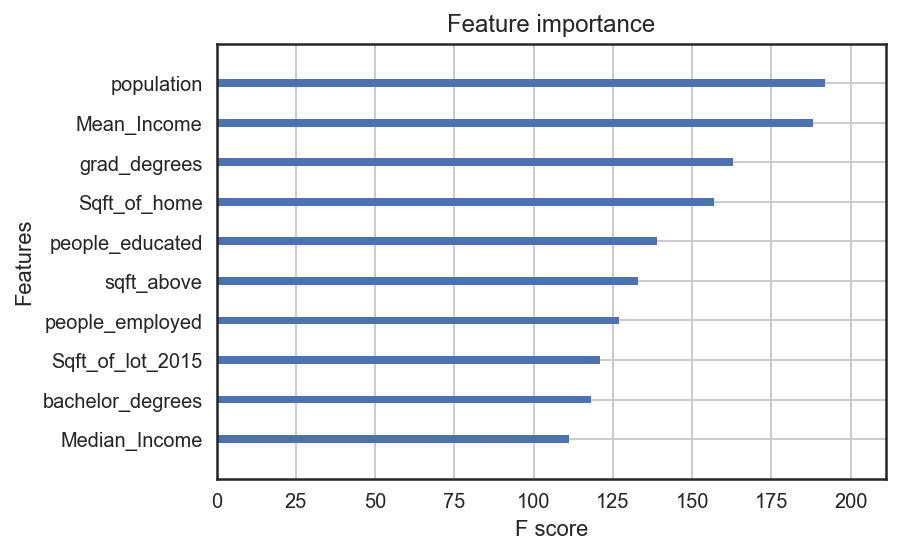

In [135]:
#Different types of feature of Importance
plot_importance(model,importance_type='weight', max_num_features = 10,show_values = False)
plot_importance(model,importance_type='gain', max_num_features = 10,show_values = False)
plot_importance(model,importance_type='cover',max_num_features = 10,show_values = False)
plt.show()

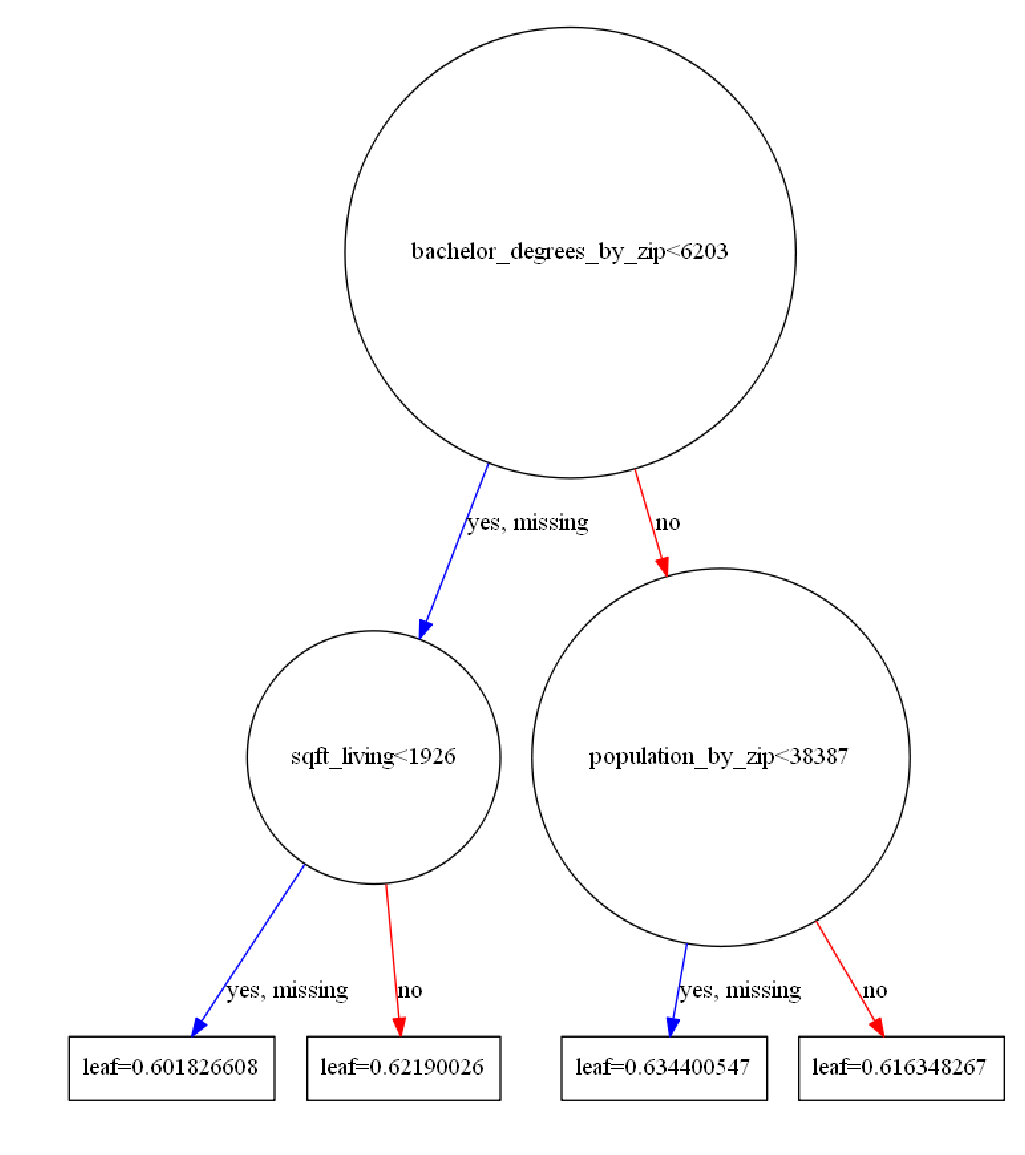

In [104]:
#Plot tree
import os
os.environ["PATH"] += os.pathsep + 'C:/Users/chend/Anaconda3/graphviz-2.38/release/bin/'
#os.environ["PATH"] 

fig, ax = plt.subplots(figsize=(10, 10))
xgb.plot_tree(model,ax =ax)
fig1 = plt.gcf()
plt.show()
fig1.savefig("tree.png")

(0, 1)

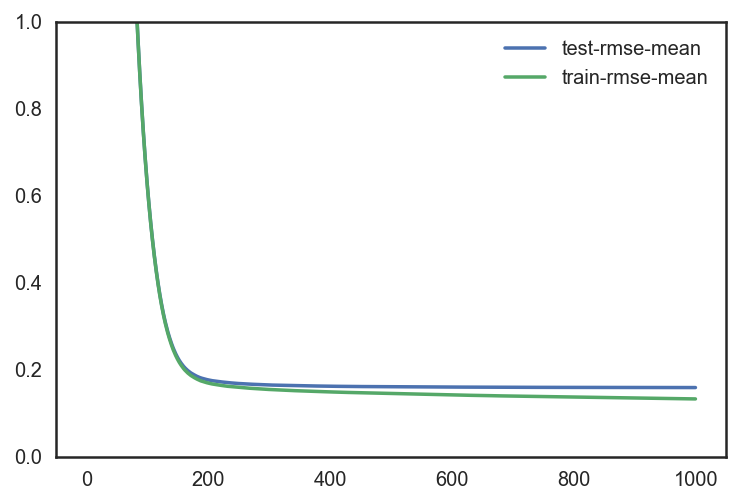

In [181]:
# The training error and the testing error in Cross Validation
model2 = xgb.cv(params, dtrain, num_boost_round=1000, early_stopping_rounds=100)
model2.loc[:,["test-rmse-mean", "train-rmse-mean"]].plot()
plt.ylim(0,1)

In [77]:
# Calculate the difference of the training error and the testing error in the CV
test_rmse_mean = model2.loc[:,["test-rmse-mean"]]
train_rmse_mean = model2.loc[:,["train-rmse-mean"]]
log_inverse = np.exp(model2.loc[:,["test-rmse-mean", "train-rmse-mean"]])
log_inverse ['Difference'] = log_inverse.apply(lambda x: x['test-rmse-mean'] - x['train-rmse-mean'] if not np.isnan(x['train-rmse-mean']) else x['Difference'], axis=1)
log_inverse.head()

,test-rmse-mean,train-rmse-mean,Difference
0,7.986671,7.986671,3.552714e-15
1,7.504226,7.504229,-2.501409e-06
2,7.064103,7.064100,2.354701e-06
3,6.661891,6.661888,2.220630e-06
4,6.293622,6.293632,-1.048938e-05
